In [1]:
import os
import fnmatch
import uproot
import numpy as np
import plotly.offline as ofl
import plotly.graph_objs as go
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Configure plotly
ofl.init_notebook_mode(connected=True)

config = dict(displayModeBar=False, staticPlot=False, showLink=False) 
layout = {
    'xaxis': {'showgrid': True, 'gridcolor': '#ccc', 'gridwidth': 1, 'automargin': True},
    'yaxis': {'showgrid': True, 'gridcolor': '#ccc', 'gridwidth': 1, 'automargin': True},
    'barmode': 'overlay',
    'legend': {'orientation': 'h', 'y': 1.06},
    'showlegend': True,
    'margin': {'l': 50, 'r': 15, 'b': 40, 't': 5, 'pad': 5}
}

scatter_kwargs = dict(mode='markers', marker={'size': 5}, hoverinfo='none', showlegend=True)
histogram_kwargs = dict(hoverinfo='none', showlegend=True)

# Configure pandas
#pd.options.display.max_rows = 50
#pd.options.display.max_columns = None

# Configure matplotlib
mpl.rcParams['text.usetex'] = True

In [2]:
def pseudorapidity(x, y, z):
    mag = np.sqrt(x**2 + y**2 + z**2)
    costheta = np.ones_like(x)
    costheta = np.divide(z, mag, out=costheta, where=mag!=0)
    frac = np.full_like(x, np.nan)
    frac = np.divide(1-costheta, 1+costheta, out=frac, where=np.abs(costheta)<1)
    return -0.5 * np.log(frac)

In [3]:
TPC_SECTOR_DELTA_PHI = 2*np.pi/12
TPC_START = 2*TPC_SECTOR_DELTA_PHI + TPC_SECTOR_DELTA_PHI/2
TPC_END   = TPC_START - 2*np.pi
TPC_EDGES = np.linspace(TPC_START, TPC_END, 13)
# Change range to [-pi, pi]
TPC_EDGES = (TPC_EDGES + np.pi) % (2*np.pi) - np.pi
TPC_EDGE_PAIRS = list(zip(TPC_EDGES, TPC_EDGES[1:]))
TPC_SECTORS_WEST = dict(zip( np.arange(1, 13), TPC_EDGE_PAIRS))
TPC_SECTORS_EAST = dict(zip( [23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 24], TPC_EDGE_PAIRS))

In [4]:
branches = {
    'px':  'Track.mPMomentum.mX1',
    'py':  'Track.mPMomentum.mX2',
    'pz':  'Track.mPMomentum.mX3',
    'ox':  'Track.mOrigin.mX1',
    'oy':  'Track.mOrigin.mX2',
    'oz':  'Track.mOrigin.mX3',
    'nhits':  'Track.mNHitsFit',
    'nhmax':  'Track.mNHitsMax',
    'chi2':  'Track.mChi2',
    #'topo':  'Track.mTopologyMap[2]'
}

path = 'data/'
 
rootfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    #for f in fnmatch.filter(files, 'st_physics_adc_1909900*.picoDst.root')]
    #for f in fnmatch.filter(files, 'st_physics_adc_19099001_*.picoDst.root')]
    for f in fnmatch.filter(files, 'st_physics_*.picoDst.root')]

print(len(rootfiles), 'file(s)')
#rootfiles

163 file(s)


In [5]:
%%time

# Create smaller dataframes
def todf(rootfile):
    tree = uproot.open(rootfile)['PicoDst']
    df = tree.pandas.df(branches.values())
    
    ## Can select specific events for debugging
    ## idx corresponds to [entry, subentry]
    #idx = pd.IndexSlice
    #df = df.loc[ idx[13, :], : ]
    
    # Assign short names to columns
    df.columns = branches.keys()
    
    # Basic cuts
    r = np.sqrt(df['ox']*df['ox'] + df['oy']*df['oy'])
    select = np.logical_and(np.abs(df['oz']) < 60, r < 1)
    df = df.loc[select]
    
    return df


dfs = [todf(rootfile) for rootfile in rootfiles]
df = pd.concat(dfs, keys=np.arange(0, len(dfs)), names=['file'])
#df
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31129793 entries, (0, 0, 0) to (162, 978, 1022)
Data columns (total 9 columns):
px       float32
py       float32
pz       float32
ox       float32
oy       float32
oz       float32
nhits    int8
nhmax    uint8
chi2     uint16
dtypes: float32(6), int8(1), uint16(1), uint8(1)
memory usage: 1009.4 MB
CPU times: user 4min 34s, sys: 46.6 s, total: 5min 20s
Wall time: 5min 47s


In [6]:
# Add more columns
df = df.assign(
    mag=np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2),
    pt=np.sqrt(df['px']**2 + df['py']**2),
    pphi=np.arctan2(df.py, df.px),
    peta=pseudorapidity(df.px, df.py, df.pz)
)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31129793 entries, (0, 0, 0) to (162, 978, 1022)
Data columns (total 13 columns):
px       float32
py       float32
pz       float32
ox       float32
oy       float32
oz       float32
nhits    int8
nhmax    uint8
chi2     uint16
mag      float32
pt       float32
pphi     float32
peta     float32
dtypes: float32(10), int8(1), uint16(1), uint8(1)
memory usage: 1.4 GB


In [7]:
# Apply cuts
#df_mag = df.loc[np.abs(df['mag']) != 0]
#df_mag.info(memory_usage='deep')
#del df_mag

Let's look at the transverse momentum distribution, P_T < 10 GeV

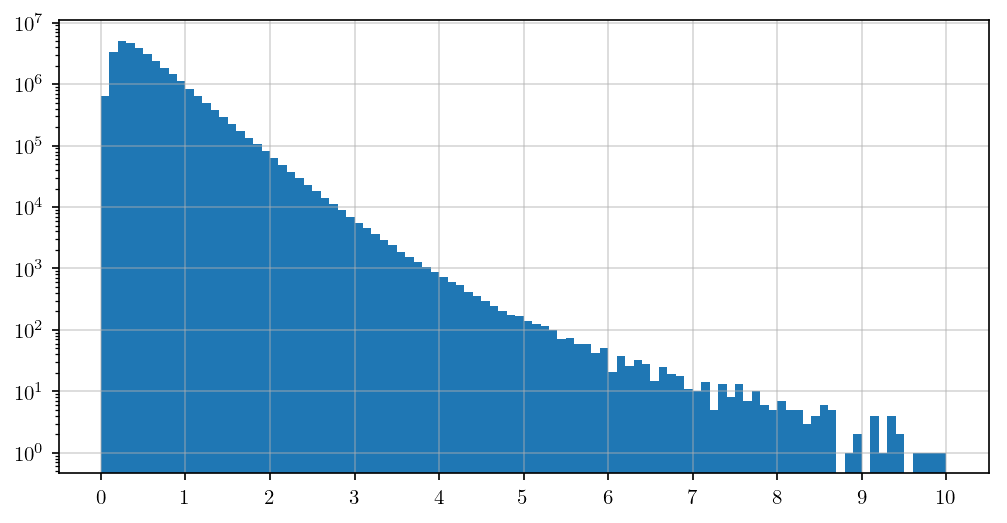

In [8]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
plt.hist(df.loc[ df['pt'] < 10]['pt'], bins=100)
plt.yscale('log')
ax.xaxis.set_ticks(np.arange(0, 11, 1))
plt.grid(alpha=0.5)
plt.show()

In [9]:
edges_pt = np.linspace(0.1, 1, 10)
edges_pt = np.append(edges_pt, np.inf)
#edges_pt

Plot phi vs eta distributions for different P_T bins

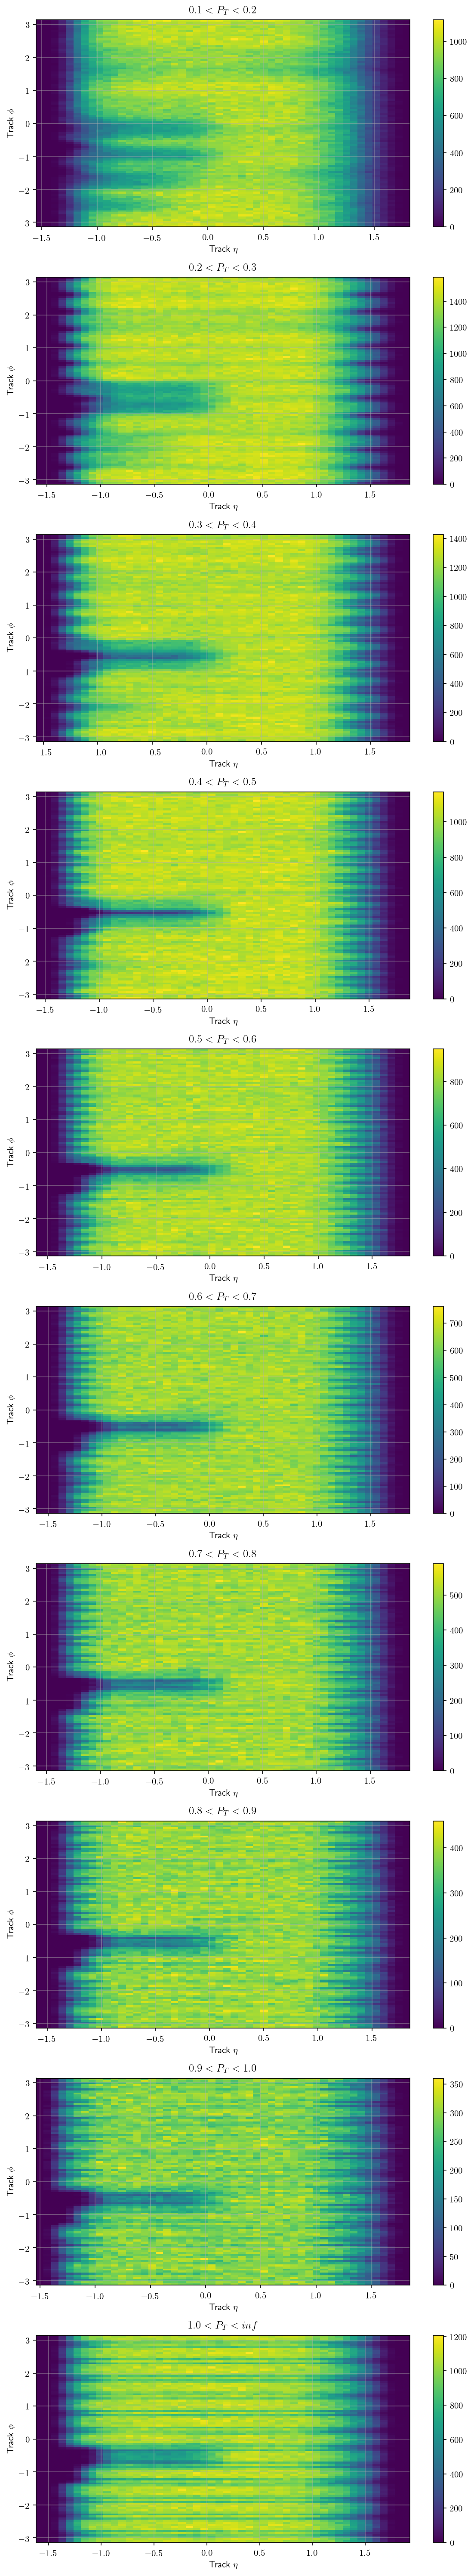

In [10]:
fig, ax = plt.subplots(10, figsize=(8, 4*10), dpi=150)

for iplot, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    #print(f'{iplot} bin: {pt_min:.1f} < P_T < {pt_max:.1f}')
    df_pt = df.loc[ (df['pt'] > pt_min) & (df['pt'] < pt_max) ]
    h = ax[iplot].hist2d(df_pt['peta'], df_pt['pphi'], bins=[50, 100]) 
    ax[iplot].set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    ax[iplot].set_xlabel(r'Track $\eta$')
    ax[iplot].set_ylabel(r'Track $\phi$')
    ax[iplot].grid(alpha=0.5)
    fig.colorbar(h[3], ax=ax[iplot])
 
plt.tight_layout()
plt.show()

Create separate samples for East and West sides of TPC

In [11]:
# We are mainly interested in the East side with iTPC sector
df_east = df.loc[ (df['peta'] <= 0) & (df['oz'] < 0) ]
df_west = df.loc[ (df['peta'] >= 0) & (df['oz'] > 0) ]
#df_east.info(memory_usage='deep')
#df_west.info(memory_usage='deep')

Plot phi distributions for different P_T bins and eta < 0 (East)

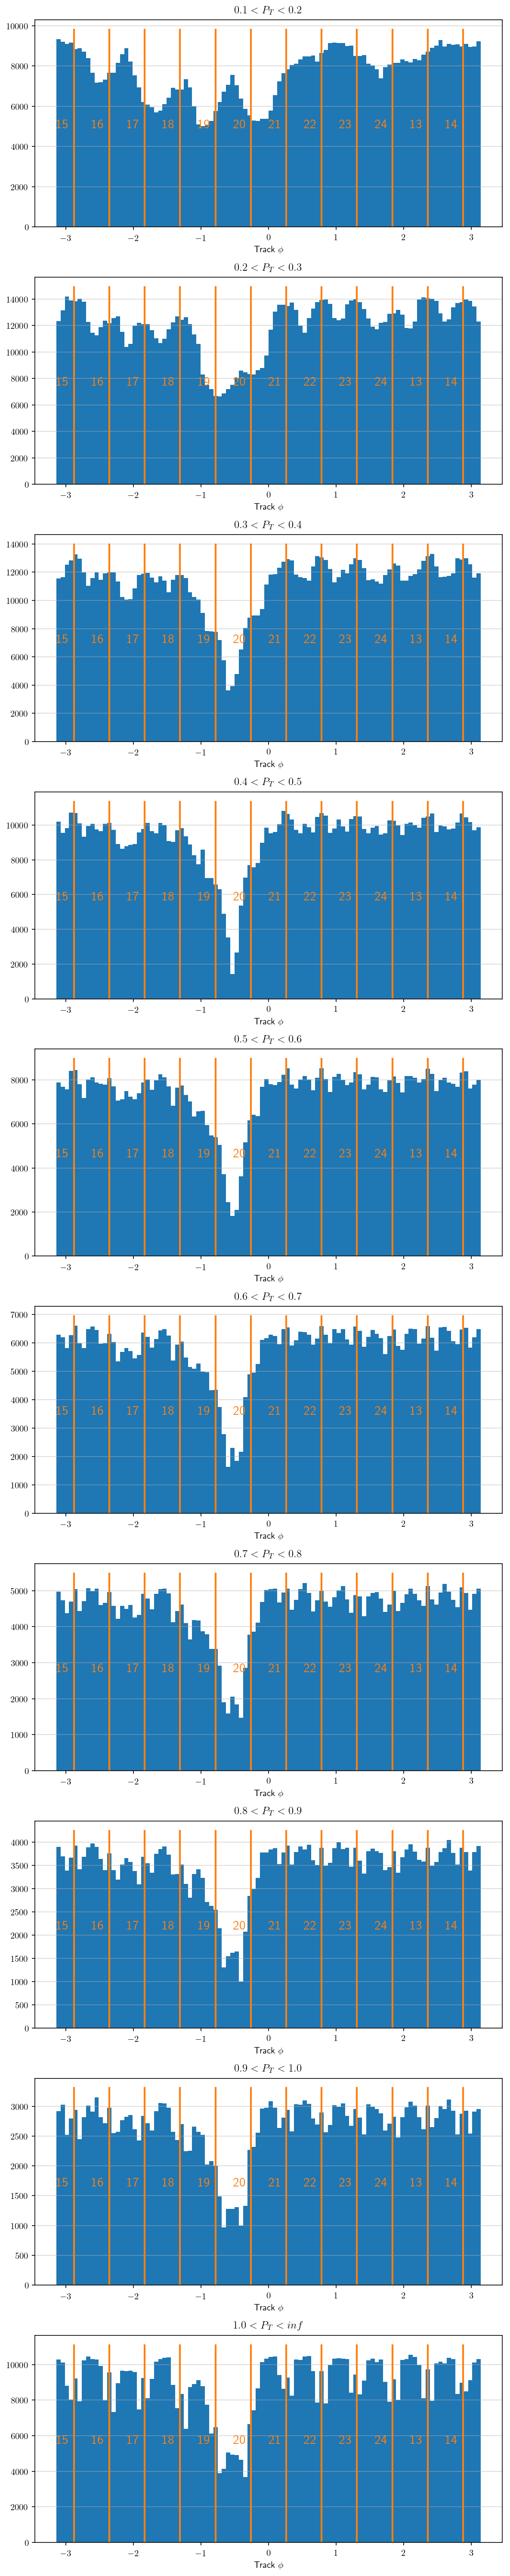

In [12]:
fig, ax = plt.subplots(10, figsize=(8, 4*10), dpi=150)

for iplot, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    #print(f'{iplot} bin: {pt_min:.1f} < P_T < {pt_max:.1f}')
    df_pt = df_east.loc[ (df_east['pt'] > pt_min) & (df_east['pt'] < pt_max) ]
    ax[iplot].hist(df_pt['pphi'], bins=100)
    ax[iplot].set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    ax[iplot].set_xlabel(r'Track $\phi$')
    ax[iplot].yaxis.grid(alpha=0.5)
    
    ylimits = ax[iplot].get_ylim()
    
    for sec, (sec_max, sec_min) in TPC_SECTORS_EAST.items():
        ax[iplot].plot([sec_max, sec_max], ylimits, 'C1-', lw=2)
        ax[iplot].text(sec_max - 0.5*TPC_SECTOR_DELTA_PHI, ylimits[1]*0.5, f'{sec}',
                       color='C1', fontsize='x-large', fontweight='black')

 
plt.tight_layout()
plt.show()

Now look at the number of hits as a function of track azimuthal angle

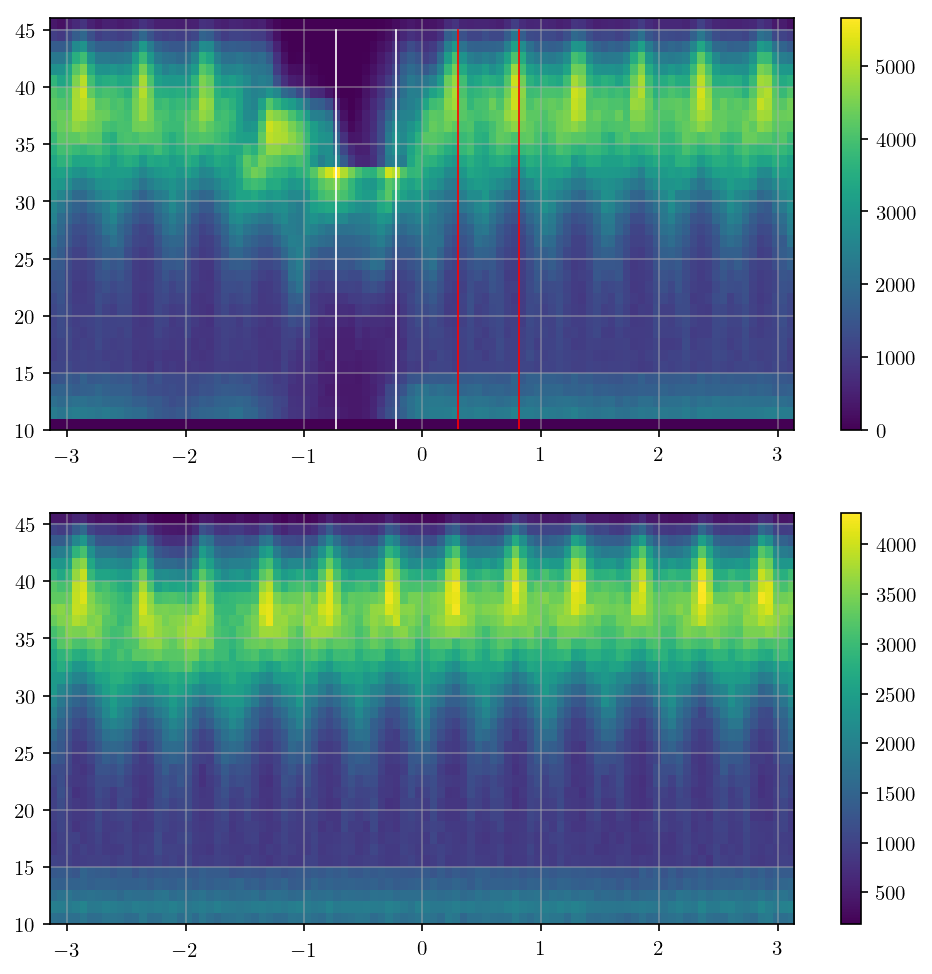

In [13]:
fig, (ax_east, ax_west) = plt.subplots(2, figsize=(8, 8), dpi=150)
h = ax_east.hist2d(df_east['pphi'], np.abs(df_east['nhits']), bins=[100, np.arange(10, 47, 1)]) #, norm=mpl.colors.LogNorm())
ax_east.plot([-0.73, -0.73], [10, 45], 'w-', lw=0.8)
ax_east.plot([-0.22, -0.22], [10, 45], 'w-', lw=0.8)
ax_east.plot([0.3, 0.3], [10, 45], 'r-', lw=0.8)
ax_east.plot([0.82, 0.82], [10, 45], 'r-', lw=0.8)
fig.colorbar(h[3], ax=ax_east)
h = ax_west.hist2d(df_west['pphi'], np.abs(df_west['nhits']), bins=[100, np.arange(10, 47, 1)]) #, norm=mpl.colors.LogNorm())
ax_east.grid(alpha=0.5)
ax_west.grid(alpha=0.5)
fig.colorbar(h[3], ax=ax_west)
plt.show()

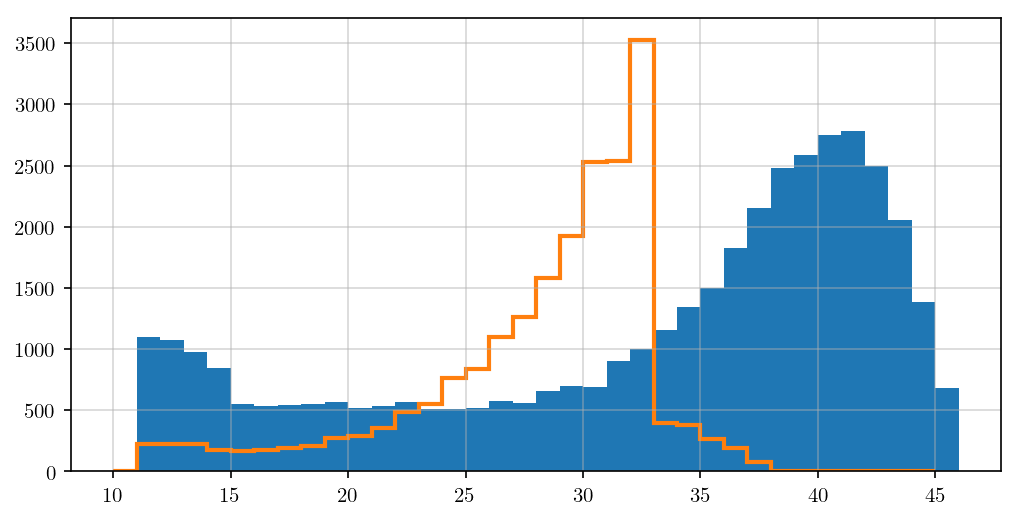

In [14]:
selection = (df_east['pphi'] > 0.3) & (df_east['pphi'] < 0.82) & (df_east['pt'] > 1)
df_god = df_east.loc[ selection ]

selection = (df_east['pphi'] > -0.73 ) & (df_east['pphi'] < -0.22 ) & (df_east['pt'] > 1)
df_bad = df_east.loc[ selection ]

#df_bad['nhits'].values

#df_god
#ws = np.ones_like(df_bad['nhits'].values, dtype='float32')
#ws *= 0.6
ws = None

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
h_god, dummy, dummy = ax.hist(df_god['nhits'], bins=np.arange(10, 47, 1))
h_bad, dummy, dummy = ax.hist(df_bad['nhits'], bins=np.arange(10, 46, 1), weights=ws, histtype='step', lw=2)
plt.grid(alpha=0.5)
plt.show()

In [15]:
print(h_god[:].sum())
print(h_bad[:].sum())

print(h_god[0:6].sum())
print(h_bad[0:6].sum())

print(h_god[-12:])
print(h_bad[-12:])

40173.0
20905.0
4552.0
1008.0
[1340. 1500. 1826. 2155. 2478. 2590. 2749. 2779. 2495. 2055. 1383.  681.]
[392. 379. 269. 191.  73.   2.   2.   0.   1.   1.   0.   0.]


Track chi2

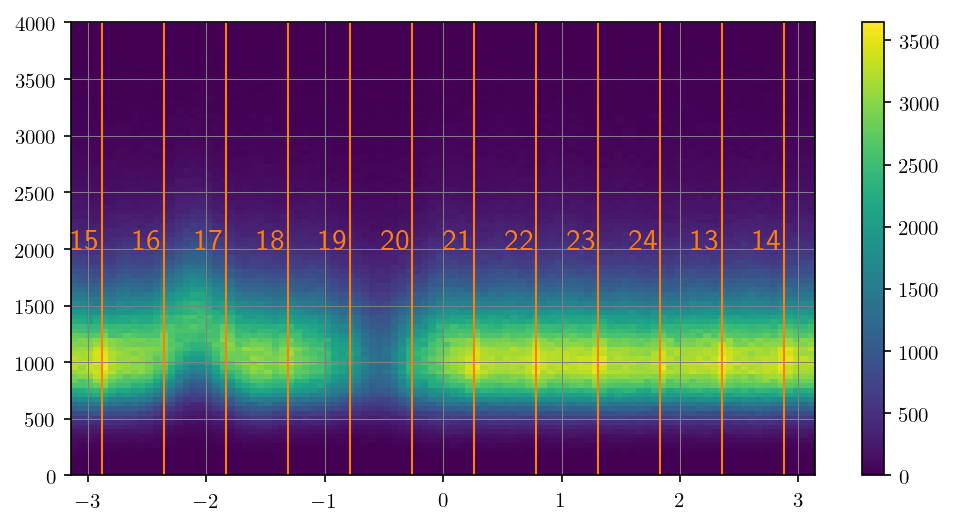

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax.grid(linestyle='-', linewidth='0.5', color='grey')
plt.hist2d(df_east['pphi'], np.abs(df_east['chi2']), bins=[100, np.linspace(0, 4000, 100)])
plt.colorbar()
plt.grid(True)

ylimits = ax.get_ylim()

for sec, (sec_max, sec_min) in TPC_SECTORS_EAST.items():
    ax.plot([sec_max, sec_max], ylimits, 'C1-', lw=1)
    ax.text(sec_max - 0.5*TPC_SECTOR_DELTA_PHI, ylimits[1]*0.5, f'{sec}',
                   color='C1', fontsize='x-large', fontweight='black')
plt.show()